In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
!pip install pmdarima

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [8]:
dfbase = pd.read_excel('/content/drive/MyDrive/Data Analytics - FIAP/tech_challenge_02/git/data/base_unificada.xlsx')
ibovespa_data = pd.read_csv("/content/drive/MyDrive/Data Analytics - FIAP/tech_challenge_02/git/data/ibovespa_2005_2023.csv")
hist_stock_data = pd.read_csv("/content/drive/MyDrive/Data Analytics - FIAP/tech_challenge_02/git/data/cota_his_stock/hist_stock.csv")
acoes_data = pd.read_excel("/content/drive/MyDrive/Data Analytics - FIAP/tech_challenge_02/git/data/acoes_mais_tempo_ibovespa.xlsx")

In [9]:
#normalizando dados da base hist
hist_stock_data = hist_stock_data.drop("Unnamed: 0", axis = 1)
hist_stock_data['Date'] = pd.to_datetime(hist_stock_data['Date'])
#açoes com mais participação
tickers = acoes_data['Ação'].unique()
#df somente com as ações de maior participação
hist_stock_more_time = hist_stock_data[hist_stock_data['Ticker'].isin(tickers)]
hist_stock_more_time = hist_stock_more_time.pivot(index='Date', columns='Ticker', values='Closing Price')
#preenchendo NaN
hist_stock_more_time.fillna(method='ffill', inplace=True)
hist_stock_more_time.fillna(method='bfill', inplace=True)

In [10]:
#normalizando dfbase
dfbase['data'] = pd.to_datetime(dfbase['data'])
dfbase = dfbase.sort_values('data')
dfbase.fillna(method='ffill', inplace=True)
dfbase.fillna(method='bfill', inplace=True)

In [27]:
#selecionado variaveis
dfbase_variable_1 = dfbase[['data', 'ultimo_valor','volume','bmp_inv_carteira','ke','ke_ipca','ke_selic_dia','ke_cpi','crescimento_pib']]

In [28]:
# Juntar os DataFrames com base na data
merged_data_01 = pd.merge(dfbase_variable_1, hist_stock_more_time, left_on='data', right_on='Date', how='inner')

# Tratar valores faltantes substituindo por a média da coluna
merged_data_01.fillna(merged_data_01.mean(), inplace=True)

<ipython-input-28-5d1cb37e909a>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  merged_data_01.fillna(merged_data_01.mean(), inplace=True)


#ARIMA - Historical Stock + df Base (bmp_inv_carteira','ke','ke_ipca','ke_selic_dia','ke_cpi','crescimento_pib)

In [ ]:
model_auto = auto_arima(merged_data_01['ultimo_valor'], trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model_auto.summary()

In [31]:
# Ajustando o modelo SARIMAX
model = SARIMAX(merged_data_01['ultimo_valor'], order=(2, 1, 2))
result = model.fit(disp=False)
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:           ultimo_valor   No. Observations:                 4593
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7060.143
Date:                Sun, 27 Aug 2023   AIC                          14130.286
Time:                        22:09:39   BIC                          14162.446
Sample:                             0   HQIC                         14141.607
                               - 4593                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5185      0.040    -38.174      0.000      -1.597      -1.441
ar.L2         -0.7182      0.039    -18.456      0.000      -0.795      -0.642
ma.L1          1.4526      0.043     34.134      0.0

In [33]:
# Predições in-sample
pred_insample = result.predict(start=1, end=len(merged_data)-1, dynamic=False)

# Previsões out-of-sample para os próximos 30 dias
forecast_30 = result.get_forecast(steps=30).predicted_mean

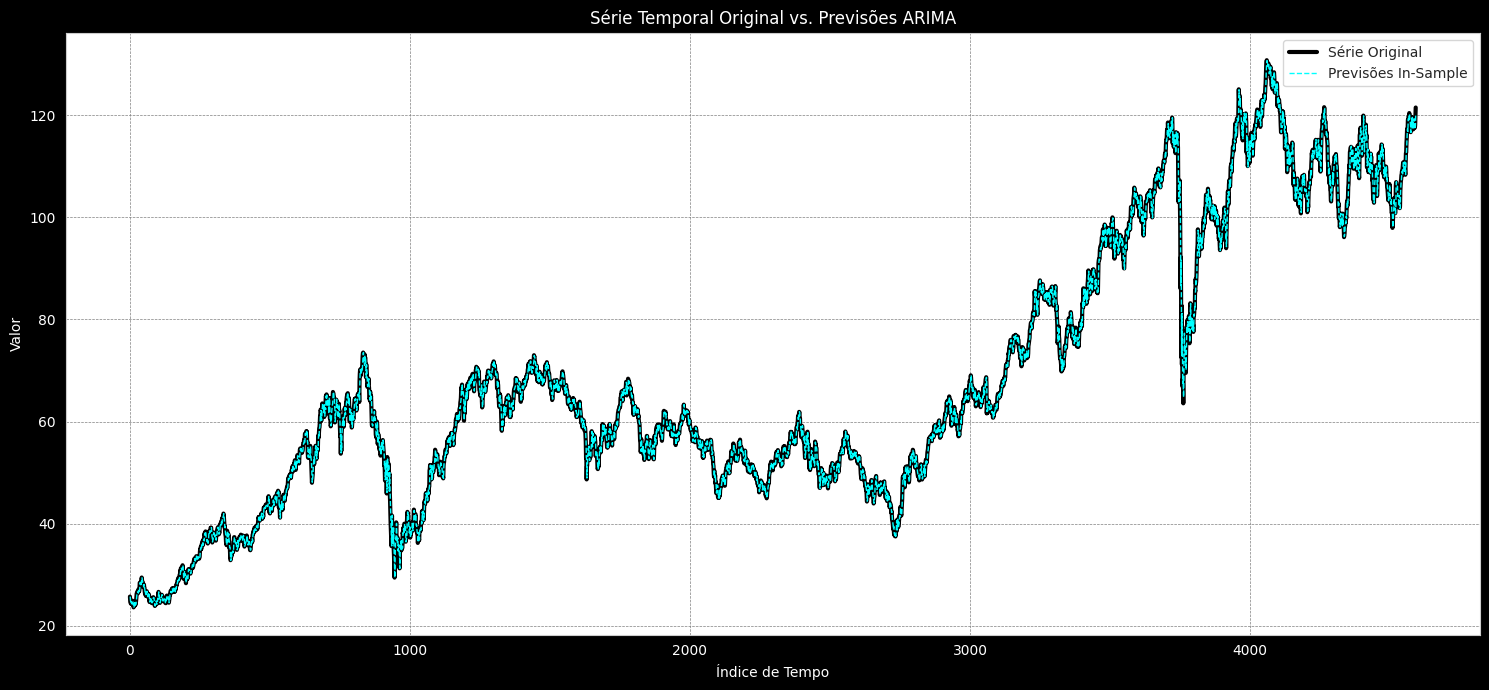

In [55]:
# Configurando o fundo para preto e ajustando cores para melhor visualização

plt.figure(figsize=(15,7), facecolor="black")

# Plotando a série e previsões com cores apropriadas para fundo preto
plt.plot(merged_data['ultimo_valor'], label="Série Original", color="black", linewidth=3)
plt.plot(merged_data.index[1:], pred_insample, label="Previsões In-Sample", color="aqua", linestyle="--", linewidth=1)

# Ajustando títulos, labels, e legendas para fundo preto
plt.title("Série Temporal Original vs. Previsões ARIMA", color="white")
plt.xlabel("Índice de Tempo", color="white")
plt.ylabel("Valor", color="white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color="gray")
plt.tight_layout()
plt.show()


In [62]:
# Calculando as métricas
mse = mean_squared_error(merged_data_01['ultimo_valor'][1:], pred_insample)
mae = mean_absolute_error(merged_data_01['ultimo_valor'][1:], pred_insample)
r2 = np.corrcoef(merged_data_01['ultimo_valor'][1:], pred_insample)[0,1]**2
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")


MSE: 50.86595395950743
MAE: 3.700108814410122
R^2: 0.924838189839899


#ARIMA df Base (bmp_inv_carteira','ke','ke_ipca','ke_selic_dia','ke_cpi','crescimento_pib)

In [ ]:
model_auto = auto_arima(dfbase_variable_1['ultimo_valor'], trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model_auto.summary()

In [58]:
# Ajustando o modelo SARIMAX
model = SARIMAX(dfbase_variable_1['ultimo_valor'], order=(2, 1, 2))
result = model.fit(disp=False)
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:           ultimo_valor   No. Observations:                 4682
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7152.006
Date:                Sun, 27 Aug 2023   AIC                          14314.012
Time:                        22:32:40   BIC                          14346.268
Sample:                             0   HQIC                         14325.355
                               - 4682                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5365      0.043    -35.764      0.000      -1.621      -1.452
ar.L2         -0.7068      0.038    -18.479      0.000      -0.782      -0.632
ma.L1          1.4689      0.045     32.288      0.0

In [68]:
# Predições in-sample
pred_insample = result.predict(start=1, end=len(dfbase_variable_1)-1, dynamic=False)

# Previsões out-of-sample para os próximos 30 dias
forecast_30 = result.get_forecast(steps=30).predicted_mean

In [69]:
# Calculando as métricas
mse = mean_squared_error(dfbase_variable_1['ultimo_valor'][1:], pred_insample)
mae = mean_absolute_error(dfbase_variable_1['ultimo_valor'][1:], pred_insample)
r2 = np.corrcoef(dfbase_variable_1['ultimo_valor'][1:], pred_insample)[0,1]**2
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

MSE: 1.2434360090602818
MAE: 0.7764810409222893
R^2: 0.9981545041967038


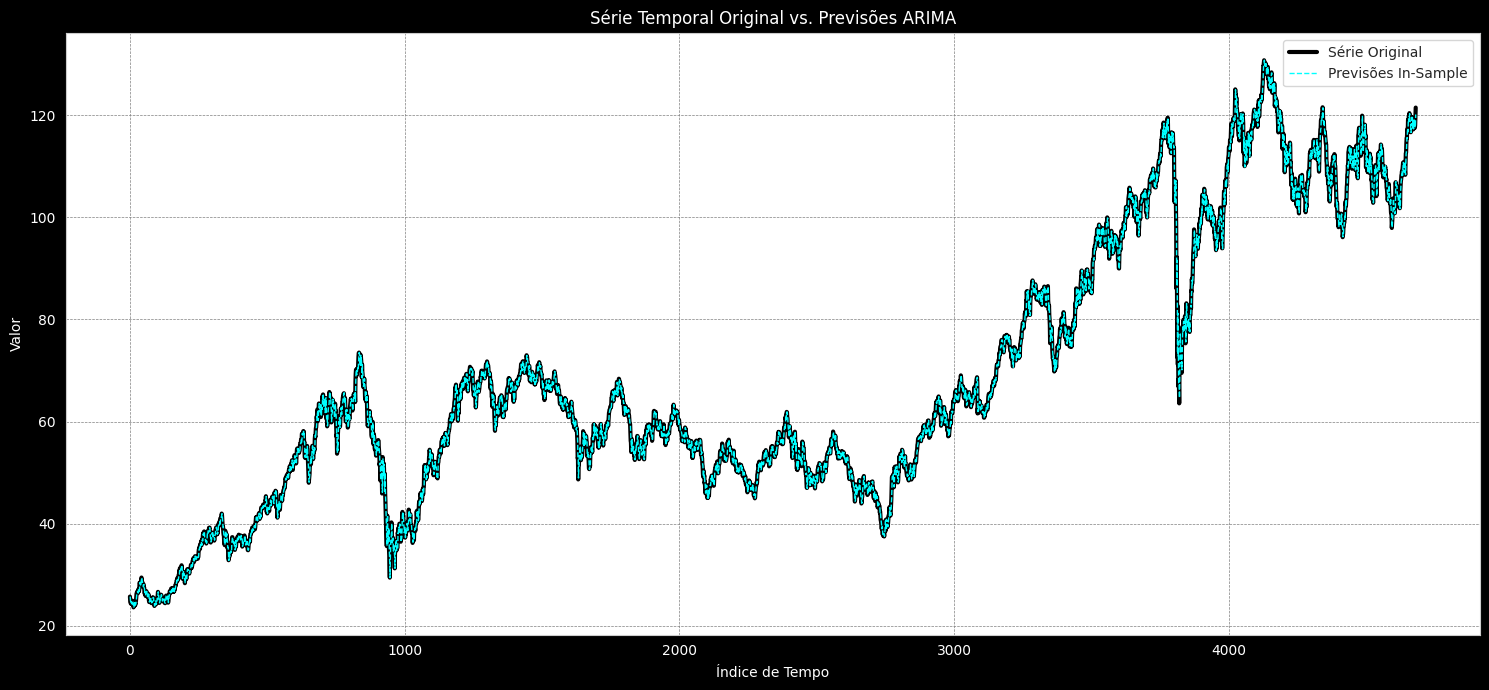

In [70]:

plt.figure(figsize=(15,7), facecolor="black")

plt.plot(dfbase_variable_1['ultimo_valor'], label="Série Original", color="black", linewidth=3)
plt.plot(dfbase_variable_1.index[1:], pred_insample, label="Previsões In-Sample", color="aqua", linestyle="--", linewidth=1)

plt.title("Série Temporal Original vs. Previsões ARIMA", color="white")
plt.xlabel("Índice de Tempo", color="white")
plt.ylabel("Valor", color="white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color="gray")
plt.tight_layout()
plt.show()
